# GRAD-E1326: Python Programming for Data Scientists
## Ph.D. Hannah Béchara
### Ji Yoon Han & Mariana G. Carrillo 

**Initial Project report: Tweet Sentiment Analysis**


In [3]:
#Importing libraries for sentiment analysis 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk #Natural Language Processing Package 
import os #functions for interacting with the operating system
import spacy #Models for NLP
import torch #also for NLP
from tqdm.notebook import tqdm 
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
import transformers #contains pretrained models to perform tasks on texts
from transformers import BertForSequenceClassification
from wordcloud import WordCloud #For nice wordclouds
import tensorflow as tf #Package to develop train models 
from tensorflow.keras.preprocessing import text 
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
import time #for handling dates and times
import re 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.metrics import AUC
from sklearn.metrics import confusion_matrix, classification_report


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Loading data

In [4]:
#Loading and cleaning data
train_data = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin-1')

In [19]:
#Train data 
#preview
train_data.head(5)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [29]:

#info on nulls
train_data.info



<bound method DataFrame.info of        UserName  ScreenName                      Location     TweetAt  \
0          3799       48751                        London  16-03-2020   
1          3800       48752                            UK  16-03-2020   
2          3801       48753                     Vagabonds  16-03-2020   
3          3802       48754                           NaN  16-03-2020   
4          3803       48755                           NaN  16-03-2020   
...         ...         ...                           ...         ...   
41152     44951       89903  Wellington City, New Zealand  14-04-2020   
41153     44952       89904                           NaN  14-04-2020   
41154     44953       89905                           NaN  14-04-2020   
41155     44954       89906                           NaN  14-04-2020   
41156     44955       89907  i love you so much || he/him  14-04-2020   

                                           OriginalTweet           Sentiment  
0      @MeNy

In [21]:
#descriptive statistics
train_data.describe()

,UserName,ScreenName
count,41157.000000,41157.000000
mean,24377.000000,69329.000000
std,11881.146851,11881.146851
min,3799.000000,48751.000000
25%,14088.000000,59040.000000
50%,24377.000000,69329.000000
75%,34666.000000,79618.000000
max,44955.000000,89907.000000


In [22]:
#Test data
#preview
test_data.head(5)




,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


Data pre-processing

In [23]:

#info on nulls
test_data.info



<bound method DataFrame.info of       UserName  ScreenName             Location     TweetAt  \
0            1       44953                  NYC  02-03-2020   
1            2       44954          Seattle, WA  02-03-2020   
2            3       44955                  NaN  02-03-2020   
3            4       44956          Chicagoland  02-03-2020   
4            5       44957  Melbourne, Victoria  03-03-2020   
...        ...         ...                  ...         ...   
3793      3794       48746            Israel ??  16-03-2020   
3794      3795       48747       Farmington, NM  16-03-2020   
3795      3796       48748        Haverford, PA  16-03-2020   
3796      3797       48749                  NaN  16-03-2020   
3797      3798       48750  Arlington, Virginia  16-03-2020   

                                          OriginalTweet           Sentiment  
0     TRENDING: New Yorkers encounter empty supermar...  Extremely Negative  
1     When I couldn't find hand sanitizer at Fred Me...

In [24]:
#descriptive statistics
test_data.describe()

,UserName,ScreenName
count,3798.000000,3798.000000
mean,1899.500000,46851.500000
std,1096.532489,1096.532489
min,1.000000,44953.000000
25%,950.250000,45902.250000
50%,1899.500000,46851.500000
75%,2848.750000,47800.750000
max,3798.000000,48750.000000


In [7]:
stop_words = stopwords.words('english') #defining var to remove stopwords in the process_tweet function 

#create a function that allows to process the tweets by:
def process_tweet(tweet):
    
    # removing urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    
    # removing html tags
    tweet = re.sub(r'<.*?>', ' ', tweet)
    
    # removing digits
    tweet = re.sub(r'\d+', ' ', tweet)
    
    # removing hashtags
    tweet = re.sub(r'#\w+', ' ', tweet)
    
    # removing mentions
    tweet = re.sub(r'@\w+', ' ', tweet)
    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    
    return tweet




### Exploratory Data analysis

Text(0.5, 0.98, 'Histogram of tweet distribution per sentiment classification (Test data)')

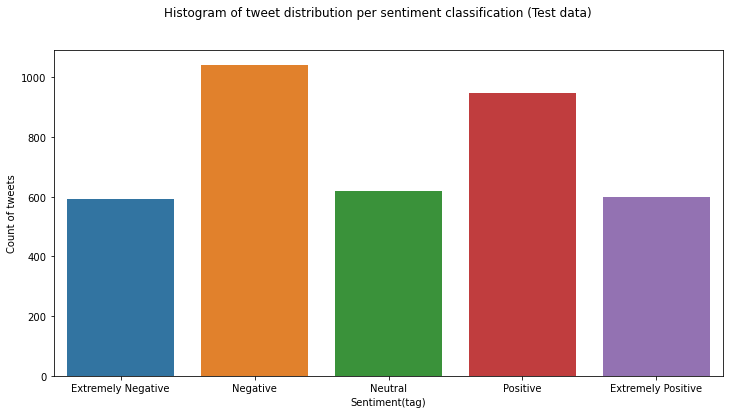

In [27]:


#Create histogram --> Distribution TEST DATA
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment', data=test_data, order=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], )
plt.xlabel('Sentiment(tag)')
plt.ylabel('Count of tweets')
plt.suptitle('Histogram of tweet distribution per sentiment classification (Test data)')


Text(0.5, 0.98, 'Histogram of tweet distribution per sentiment classification (Train data)')

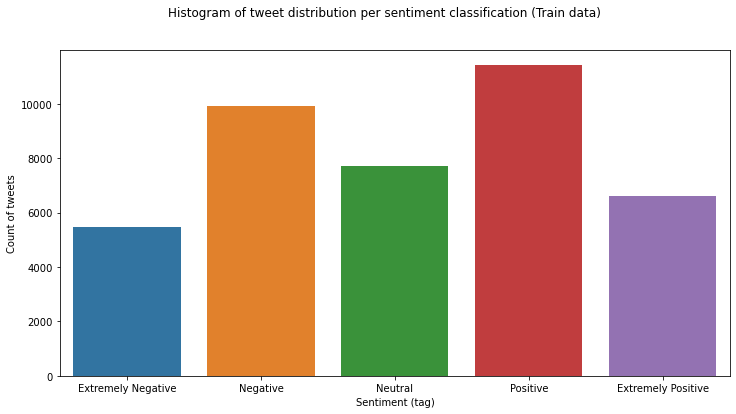

In [28]:
#Create histogram --> Distribution TRAIN DATA
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment', data=train_data, order=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], )
plt.xlabel('Sentiment (tag)')
plt.ylabel('Count of tweets')
plt.suptitle('Histogram of tweet distribution per sentiment classification (Train data)')

In [ ]:
wordCloud_generator(data['Review'], title="Most used words in reviews")

### Tokenization

* 

### References 
* Matplotlib.org. 2020. Pyplot Tutorial — Matplotlib 3.3.2 Documentation. [online] Available at: <https://matplotlib.org/tutorials/introductory/pyplot.html> [Accessed 20 October 2020].
* Kaggle.com. 2020. Hotel Reviews Sentiment Prediction. [online] Available at: <https://www.kaggle.com/shahraizanwar/hotel-reviews-sentiment-prediction> [Accessed 28 October 2020].
* 